# [Feature Importance](https://christophm.github.io/interpretable-ml-book/lime.html): From local to Global
### From 50 data instances we plot Feature impact and feature values for each growth rate $f\sigma_8$ data point <br /> This are the plots in our [work](https://arxiv.org/abs/2406.08351) on Interpretable Machine Learning.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import ast
import re

### Read the data created using [Lime](https://github.com/marcotcr/lime.git)

In [2]:
def parse_string_to_array(s):
    return np.fromstring(s.strip('[]'), sep=' ')

def extract_numbers(s):
    return [float(num) for num in re.findall(r'-?\d+\.\d+', s)]

In [3]:
#Read the instance loop
df = pd.read_csv('./data/50_instances_LimeExplanations.csv')
L_prob = np.array(df.iloc[1].values) #LOCAL PROBS
predicted_targets = np.array(df.iloc[2].values)

### And the data simulated from perturbation theory and the density field $\delta_m$

In [4]:
fs8_values = pd.read_csv('./data/fs8_fR0_Test_5000samples_Lime.csv')
fs8_values = fs8_values[:50] #each number contains the i-th fs8 values
orig_targets = fs8_values.pop("target")

fs8_values_LCDM = []
fs8_values_HS = []
true_lcdm=0
true_hs=0
for i in range(len(fs8_values)):
    if orig_targets[i]==0:
        fs8_values_LCDM.append(fs8_values.values[i])
        true_lcdm=true_lcdm+1
    else:
        fs8_values_HS.append(fs8_values.values[i])
        true_hs=true_hs+1

np.array(fs8_values_LCDM)[:, 0] #fs8_1 LCDM
np.array(fs8_values_HS)[:, 0] #fs8_1 HS

array([0.47198253, 0.50099245, 0.39610333, 0.38861188, 0.37690197,
       0.52694767, 0.5188043 , 0.47748576, 0.37861988, 0.36709671,
       0.41646888, 0.40033353, 0.42484905, 0.41244184, 0.46966362,
       0.42412493, 0.42804265, 0.43224065, 0.4567514 , 0.51176414,
       0.46433267, 0.40855231, 0.37038571, 0.36044298, 0.43498807,
       0.39036891, 0.41795978, 0.42483797, 0.4071022 , 0.40834731])

### Order the $f\sigma_8$ features wrt its redshit $z\in[0.05,1.95]$

In [5]:
ordered_features=[]

for i in range(len(L_prob)):
    #Decode to string
    input_string = L_prob[i]
    pattern = r"fs8_\d+"
    matches = re.findall(pattern, input_string)
    processed_matches = [float(x) if re.match(r"[-+]?\d*\.\d+|\d+", x) else x for x in matches]
    filtered_matches = []
    i = 0
    while i < len(processed_matches):
        if isinstance(processed_matches[i], str) and 'fs8_' in processed_matches[i]:
            filtered_matches.append(processed_matches[i])
            if i + 1 < len(processed_matches) and isinstance(processed_matches[i + 1], float):
                filtered_matches.append(processed_matches[i + 1])
        i += 1

    ordered_features.append(filtered_matches)

local_probabilities = []
for i in range(len(L_prob)):
    input_string = L_prob[i]
    pattern = r",\s*(-?\d+\.\d+)" 
    matches = re.findall(pattern, input_string)
    numerical_values = [float(value) for value in matches]
    local_probabilities.append(numerical_values)

#Match the feature names with local probabilities
list = [[[ordered_features[j][i], local_probabilities[j][i], predicted_targets[j]] for i in range(len(local_probabilities[j]))] for j in range(len(local_probabilities))]
#Sort the features
list = [sorted(list[i], key=lambda x: int(x[0].split('_')[1])) for i in range(len(list))]

In [6]:
#Sepparate in features, to get the statistics list[realization:50][feature: 16][fs8,prob: 2]
fs8_s_f = [[[list[i][j][0], list[i][j][1], list[i][j][2]] for i in range(len(list))] for j in range(len(list[0]))]

#Separate in model class prediction
fs8_probs_LCDM = []
fs8_probs_HS = []
lcdm=0
hs=0
for i in range(len(fs8_s_f)): #up to 16
    for j in range(len(fs8_s_f[0])): #up to 50
        if (int(fs8_s_f[i][j][2][0])==0):
            fs8_probs_LCDM.append(fs8_s_f[i][j])
        else:
            fs8_probs_HS.append(fs8_s_f[i][j])

#Get rid of the target
fs8_loc_pro_LCDM = np.array(fs8_probs_LCDM)[:, :-1] #get rid of the target (last element of each row)
fs8_loc_pro_HS = np.array(fs8_probs_HS)[:, :-1]

In [7]:
HS_cases = [i[-1] for i in fs8_probs_HS]
LCDM_cases = [i[-1] for i in fs8_probs_LCDM]
lcdm=int(len(LCDM_cases)/16) #LCDM predicted cases =25
hs=int(len(HS_cases)/16) #HS predicted cases =25
true_lcdm #original LCDM
true_hs #original HS

#Reshape the fs8_i values in subarrays. Original shapes of 320x2
fs8_loc_pro_LCDM = fs8_loc_pro_LCDM.reshape(16,int(lcdm),2)
fs8_loc_pro_HS = fs8_loc_pro_HS.reshape(16,int(hs),2)

## Global  [explanations plots](https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models)
### Feature vs Feature value vs Feature explanation (Feature impact in our [paper](https://arxiv.org/abs/2406.08351))

In [10]:
import seaborn as sns
feature_names = ['$f\\sigma_8(z_{'+ str(i+1) +'})$' for i in range(len(fs8_loc_pro_LCDM))]

feature_impacts_LCDM=[]
for i in range(len(fs8_loc_pro_LCDM)):
    feature_impacts_LCDM.append(np.array([float(item[0]) for item in fs8_loc_pro_LCDM[i][:, 1:]]))

feature_values_LCDM = [np.array(fs8_values_LCDM)[:, i] for i in range(len(fs8_values_LCDM[0]))]

In [11]:
data = pd.DataFrame(np.array(feature_values_LCDM).T, columns=feature_names)
impacts = pd.DataFrame(np.array(feature_impacts_LCDM).T, columns=feature_names)

### Plot for ΛCDM samples:

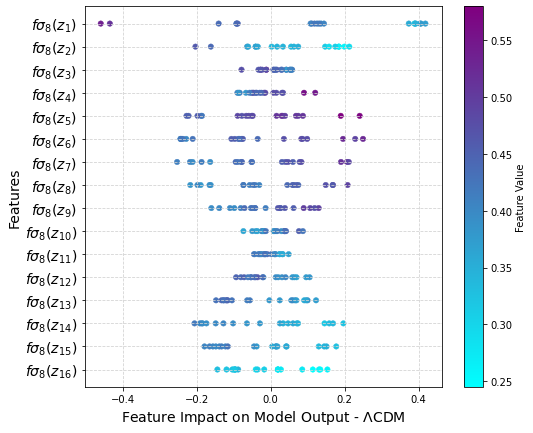

In [12]:
from matplotlib.colors import LinearSegmentedColormap
melted_data = pd.melt(data, var_name='Feature', value_name='Feature Value')
melted_impacts = pd.melt(impacts, var_name='Feature', value_name='Impact')

plot_data = melted_data.copy()
plot_data['Impact'] = melted_impacts['Impact']

purple_green = LinearSegmentedColormap.from_list("purple_green", ["cyan", "purple"])

plt.figure(figsize=(8, 7))

scatter_plot = sns.scatterplot(
    data=plot_data, x='Impact', y='Feature',
    hue='Feature Value', palette=purple_green, edgecolor=None,
    s=30, legend=None
)
plt.yticks(fontsize=14) 
plt.xlabel('Feature Impact on Model Output - $\Lambda$CDM', fontsize=14)
plt.ylabel('Features', fontsize=14)

#For color bar of feature values
norm = plt.Normalize(plot_data['Feature Value'].min(), plot_data['Feature Value'].max())
sm = plt.cm.ScalarMappable(cmap=purple_green, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Feature Value')
plt.grid(color='lightgray', linestyle='--')
plt.savefig('./figures/Feat_Impact_LCDM.pdf')
plt.show()

In [13]:
feature_impacts_HS=[]
for i in range(len(fs8_loc_pro_HS)):
    feature_impacts_HS.append(np.array([float(item[0]) for item in fs8_loc_pro_HS[i][:, 1:]]))

feature_values_HS = [np.array(fs8_values_HS)[:, i] for i in range(len(fs8_values_HS[0]))]

In [14]:
data = pd.DataFrame(np.array(feature_values_HS).T, columns=feature_names)
impacts = pd.DataFrame(np.array(feature_impacts_HS).T, columns=feature_names)

### Plot for HS samples:

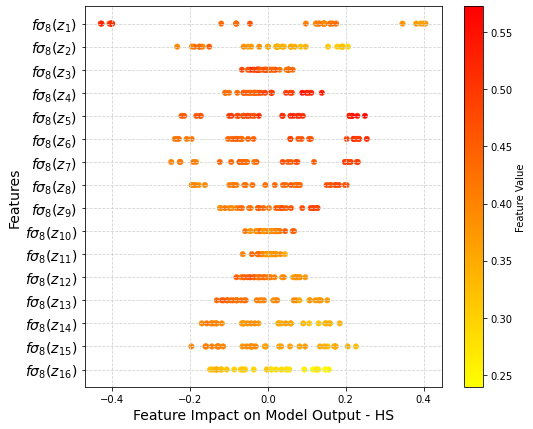

In [15]:
melted_data = pd.melt(data, var_name='Feature', value_name='Feature Value')
melted_impacts = pd.melt(impacts, var_name='Feature', value_name='Impact')

plot_data = melted_data.copy()
plot_data['Impact'] = melted_impacts['Impact']

purple_green = LinearSegmentedColormap.from_list("red_yellow", ["yellow", "red"])

plt.figure(figsize=(8, 7))

scatter_plot = sns.scatterplot(
    data=plot_data, x='Impact', y='Feature',
    hue='Feature Value', palette=purple_green, edgecolor=None,
    s=30, legend=None
)

plt.yticks(fontsize=14)
plt.xlabel('Feature Impact on Model Output - HS', fontsize=14)
plt.ylabel('Features', fontsize=14)

#For color bar of feature values
norm = plt.Normalize(plot_data['Feature Value'].min(), plot_data['Feature Value'].max())
sm = plt.cm.ScalarMappable(cmap=purple_green, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Feature Value')
plt.grid(color='lightgray', linestyle='--')
plt.savefig('./figures/Feat_Impact_HS.pdf')
plt.show()